In [49]:
import pandas as pd
pd.set_option('display.max_rows', None)
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
def create_metrics_comparison(results_path="../results"):
    """
    Create a comparison table for different models using all evaluation metrics.
    """
    
    # Metric configuration
    metric_config = {
        'WAPE': {'format': '{:.1f}%'},
        'MAPE': {'format': '{:.1f}%'},
        'R²': {'format': '{:.3f}'},
        'MSE': {'format': '{:.1f}'},
        'RMSE': {'format': '{:.1f}'},
        'MAE': {'format': '{:.0f}'},
    }
    
    # Load results
    dfs = []
    for file_path in glob(os.path.join(results_path, "*average_results.csv")):
        df = pd.read_csv(file_path, index_col=0)
        df['Source_File'] = os.path.basename(file_path)
        dfs.append(df)

    all_models_results = pd.concat(dfs, ignore_index=True)

    # Mapping dictionaries with defined order y agregando Lasso y Ridge
    model_names = {
        'LinearRegression': 'LR',
        'KNeighborsRegressor': 'KNN \n(Base line)',
        'RandomForestRegressor': 'RF\n(Best)',
        'XGBRegressor': 'XGB',
        'CatBoostRegressor': 'CAT',
        'LR Lasso': 'Lasso',   
        'LR Ridge': 'Ridge'    
    }
    
    strategy_names = {
        'within_domain': 'Within Domain',
        'cross_domain': 'Cross Domain',
        'all_domain': 'All Domain'
    }

    target_names = {
        'Non-residential EUI (kWh/m2/year)': 'Non-residential',
        'Residential EUI (kWh/m2/year)': 'Residential'
    }

    # Apply mappings
    all_models_results['Strategy'] = all_models_results['Strategy'].map(strategy_names)
    all_models_results['Model'] = all_models_results['Model'].map(model_names)
    all_models_results['Target'] = all_models_results['Target'].map(target_names)

    model_order = ['KNN \n(Base line)','LR', 'Lasso', 'Ridge', 'RF\n(Best)', 'XGB', 'CAT']
    all_models_results['Model'] = pd.Categorical(
        all_models_results['Model'],
        categories=model_order,
        ordered=True
    )

    # Create full detailed table with ordered metrics
    metrics = ['MAPE', 'R²', 'MSE', 'MAE', 'WAPE', 'RMSE']
    
    full_table = pd.pivot_table(
        all_models_results,
        index=['Model', 'Target', 'Model Details','Features Used','Features Abbreviated'],
        columns=['Strategy'],
        values=metrics,
        aggfunc='mean'
    ).sort_index(level=0)

    # Format the values according to metric configuration
    formatted_table = full_table.copy()
    for metric in metrics:
        for strategy in strategy_names.values():
            col = (metric, strategy)
            formatted_table[col] = formatted_table[col].apply(
                lambda x: metric_config[metric]['format'].format(x)
            )
    #df_flat = formatted_table.copy()
    #df_flat.columns = [f"{col[0]} {col[1]}" if col[1] != '' else col[0] for col in formatted_table.columns]

    return formatted_table


In [51]:
def create_model_comparison(comparison_table, metric, save_path=None, y_limits=None):
    """
    Create a comparison plot for different models using a specified metric.
    
    Parameters:
    -----------
    comparison_table : pd.DataFrame
        The formatted table from create_metrics_comparison function
    metric : str
        The metric to compare. Options: 'MAPE', 'R²', 'MSE', 'RMSE', 'MAE', 'WAPE'
    save_path : str
        The path where the plot should be saved
    y_limits : tuple, optional
        A tuple of (min, max) values to set the y-axis limits manually. 
        If None, limits will be set automatically based on the data and metric type.
    
    Returns:
    --------
    matplotlib.figure.Figure
        The generated plot
    """
    
    # Metric configuration with average labels
    metric_config = {
        'R²': {'format': '%.2f', 'label': 'Avg. R²', 'limits': (-1, 1)},
        'MSE': {'format': '%.0f', 'label': 'Avg. MSE', 'limits': (0, None)},
        'RMSE': {'format': '%.1f', 'label': 'Avg. RMSE', 'limits': (0, None)},
        'MAE': {'format': '%.1f', 'label': 'Avg. MAE', 'limits': (0, None)},
        'WAPE': {'format': '%.1f%%', 'label': 'Avg. WAPE (%)', 'limits': (0, 100)},
        'MAPE': {'format': '%.0f%%', 'label': 'Avg. MAPE (%)', 'limits': (0, 100)}
    }
    
    # Prepare data for plotting
    plot_data = comparison_table[metric].reset_index()
    plot_data = plot_data.melt(id_vars=['Model', 'Target'], 
                              var_name='Strategy', 
                              value_name=metric)
    
    # Convert string percentages to float for plotting
    if metric in ['MAPE', 'WAPE']:
        plot_data[metric] = plot_data[metric].str.rstrip('%').astype(float)
    else:
        plot_data[metric] = plot_data[metric].astype(float)

    # Create plot
    fig, axes = plt.subplots(1, 3, figsize=(22, 8))
    strategies = ['Within Domain', 'Cross Domain', 'All Domain']

    # Set y-axis limits based on provided limits or calculate them dynamically
    if y_limits is not None:
        y_min, y_max = y_limits
    else:
        # Calculate dynamic limits
        min_val = plot_data[metric].min()
        max_val = plot_data[metric].max()
        padding = (max_val - min_val) * 0.1
        
        # Set y-axis limits based on metric configuration
        base_min, base_max = metric_config[metric]['limits']
        y_min = base_min if base_min is not None else max(min_val - padding, 0)
        y_max = base_max if base_max is not None else max_val + padding

    for ax, strategy in zip(axes, strategies):
        strategy_data = plot_data[plot_data['Strategy'] == strategy]
        
        # Get unique models and targets for custom coloring
        models = strategy_data['Model'].unique()
        targets = strategy_data['Target'].unique()
        
        # Create an empty list to store bar containers
        containers = []
        
        # Define custom colors for each model and target combination
        # Regular color palette for all models except KNN
        regular_palette = {
            'Non-residential': '#ffdabd', 
            'Residential': '#c4d8ea'
        }

        
        # Special colors for KNN
        knn_palette = {
            'Non-residential': '#fcaa70', 
            'Residential': '#84aaca'       
        }
        
        # Plot each target separately to handle custom coloring
        for target in targets:
            target_data = strategy_data[strategy_data['Target'] == target]
            
            # Create a list to store colors for each bar
            colors = []
            for model in target_data['Model']:
                if (model == 'KNN \n(Base line)' or model == 'RF\n(Best)' ):
                    colors.append(knn_palette[target])
                else:
                    colors.append(regular_palette[target])
            
            # Create bar plot for this target
            bars = ax.bar(
                x=[i + (0.4 if target == targets[1] else 0) for i in range(len(models))],
                height=target_data[metric].values,
                width=0.4,
                label=target,
                color=colors
            )
            
            containers.append(bars)
            
            # Add value labels
            for i, bar in enumerate(bars):
                ax.text(
                    bar.get_x() + bar.get_width()/2.,
                    bar.get_height() + 0.5,
                    f"{target_data[metric].iloc[i]:.0f}%" if metric in ['MAPE', 'WAPE'] else f"{target_data[metric].iloc[i]:.2f}",
                    ha='center',
                    va='bottom',
                    fontsize=13
                )
        
        # Set x-ticks at the center of grouped bars
        ax.set_xticks([i + 0.2 for i in range(len(models))])
        ax.set_xticklabels(models, fontsize=16)
        
        # Customize appearance
        ax.set_title(f'{strategy}',
                    fontsize=20,
                    pad=20,
                    fontweight='bold')
        ax.set_ylabel(metric_config[metric]['label'], fontsize=16)
        ax.set_ylim(y_min, y_max)
        
        # Remove x-axis label
        ax.set_xlabel('')
        
        # Add baseline
        ax.axhline(y=0, color='red', linestyle='--', alpha=0.3)
        
        # Position legend with adjusted position and style
        if strategy == 'Cross Domain':
            # Create custom legend handles
            from matplotlib.patches import Patch
            legend_elements = [
                Patch(facecolor=knn_palette['Non-residential'], label='Non-residential'),
                Patch(facecolor=knn_palette['Residential'], label='Residential'),
                #Patch(facecolor=knn_palette['Non-residential'], label='Non-residential (KNN)'),
                #Patch(facecolor=knn_palette['Residential'], label='Residential (KNN)')
            ]
            
            legend = ax.legend(handles=legend_elements,
                             bbox_to_anchor=(0.5, -0.15),
                             loc='upper center',
                             ncol=2,
                             fontsize=16)
            # Remove bold from legend labels
            for text in legend.get_texts():
                text.set_fontweight('normal')
        else:
            ax.legend([],[], frameon=False)

    plt.tight_layout()

    # Save plot if requested
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
    
    # Close any existing figures to prevent double plotting
    plt.show() 
    plt.close('all')

In [52]:
comparison_table = create_metrics_comparison(results_path="../results")
comparison_table.to_csv("../results/comparison_average_results.csv")
comparison_table

MAE  \
Strategy                                                                                                                                                                                   All Domain   
Model             Target          Model Details                                      Features Used                                      Features Abbreviated                                            
KNN \n(Base line) Non-residential n_neighbors=3                                      hdd_total_year, cdd_total_year, GDP_per_capita,... HDD | CDD | GDP | URB | Lat | Long | Paris | HD...         17   
                  Residential     n_neighbors=3                                      hdd_total_year, cdd_total_year, GDP_per_capita,... HDD | CDD | GDP | URB | Lat | Long | Paris | HD...         18   
LR                Non-residential No regularization                                  hdd_total_year, cdd_total_year, GDP_per_capita,... HDD | CDD | GDP | URB | Lat | Long | Paris | HD...         38   
                  Residential     No regularization                                  hdd_total_year, cdd_total_year, GDP_per_capita,... HDD | CDD | GDP | URB | Lat | Long | Paris | HD...         24   
Lasso             Non-residential Lasso, alpha = 1.0                                 hdd_total_year, cdd_total_year, GDP_per_capita,... HDD | CDD | GDP | URB | Lat | Long | Paris | HD...         38   
                  Residential     Lasso, alpha = 1.0                                 hdd_total_year, cdd_total_year, GDP_per_capita,... HDD | CDD | GDP | URB | Lat | Long | Paris | HD...         22   
Ridge             Non-residential Ridge, alpha=1.0                                   hdd_total_year, cdd_total_year, GDP_per_capita,... HDD | CDD | GDP | URB | Lat | Long | Paris | HD...         38   
                  Residential     Ridge, alpha=1.0                                   hdd_total_year, cdd_total_year, GDP_per_capita,... HDD | CDD | GDP | URB | Lat | Long | Paris | HD...         23   
RF\n(Best)        Non-residential n_estimators=100, max_depth=None, min_samples_s... hdd_total_year, cdd_total_year, GDP_per_capita,... HDD | CDD | GDP | URB | Lat | Long | Paris | HD...         21   
                  Residential     n_estimators=100, max_depth=None, min_samples_s... hdd_total_year, cdd_total_year, GDP_per_capita,... HDD | CDD | GDP | URB | Lat | Long | Paris | HD...         17   
XGB               Non-residential n_estimators=100, max_depth=6, learning_rate=0.... hdd_total_year, cdd_total_year, GDP_per_capita,... HDD | CDD | GDP | URB | Lat | Long | Paris | HD...         21   
                  Residential     n_estimators=100, max_depth=6, learning_rate=0.... hdd_total_year, cdd_total_year, GDP_per_capita,... HDD | CDD | GDP | URB | Lat | Long | Paris | HD...         20   
CAT               Non-residential iterations=100, depth=6, learning_rate=0.1, los... hdd_total_year, cdd_total_year, GDP_per_capita,... HDD | CDD | GDP | URB | Lat | Long | Paris | HD...         20   
                  Residential     iterations=100, depth=6, learning_rate=0.1, los... hdd_total_year, cdd_total_year, GDP_per_capita,... HDD | CDD | GDP | URB | Lat | Long | Paris | HD...         19   

                                                                                                                                                                                                         \
Strategy                                                                                                                                                                                   Cross Domain   
Model             Target          Model Details                                      Features Used                                      Features Abbreviated                                              
KNN \n(Base line) Non-residential n_neighbors=3                                      hdd_total_year, cdd_total_year, GDP_per_capita,... HDD | CDD | GDP | URB | Lat | L

In [53]:
comparison_table = comparison_table.reset_index(level=[2, 3, 4], drop=True)

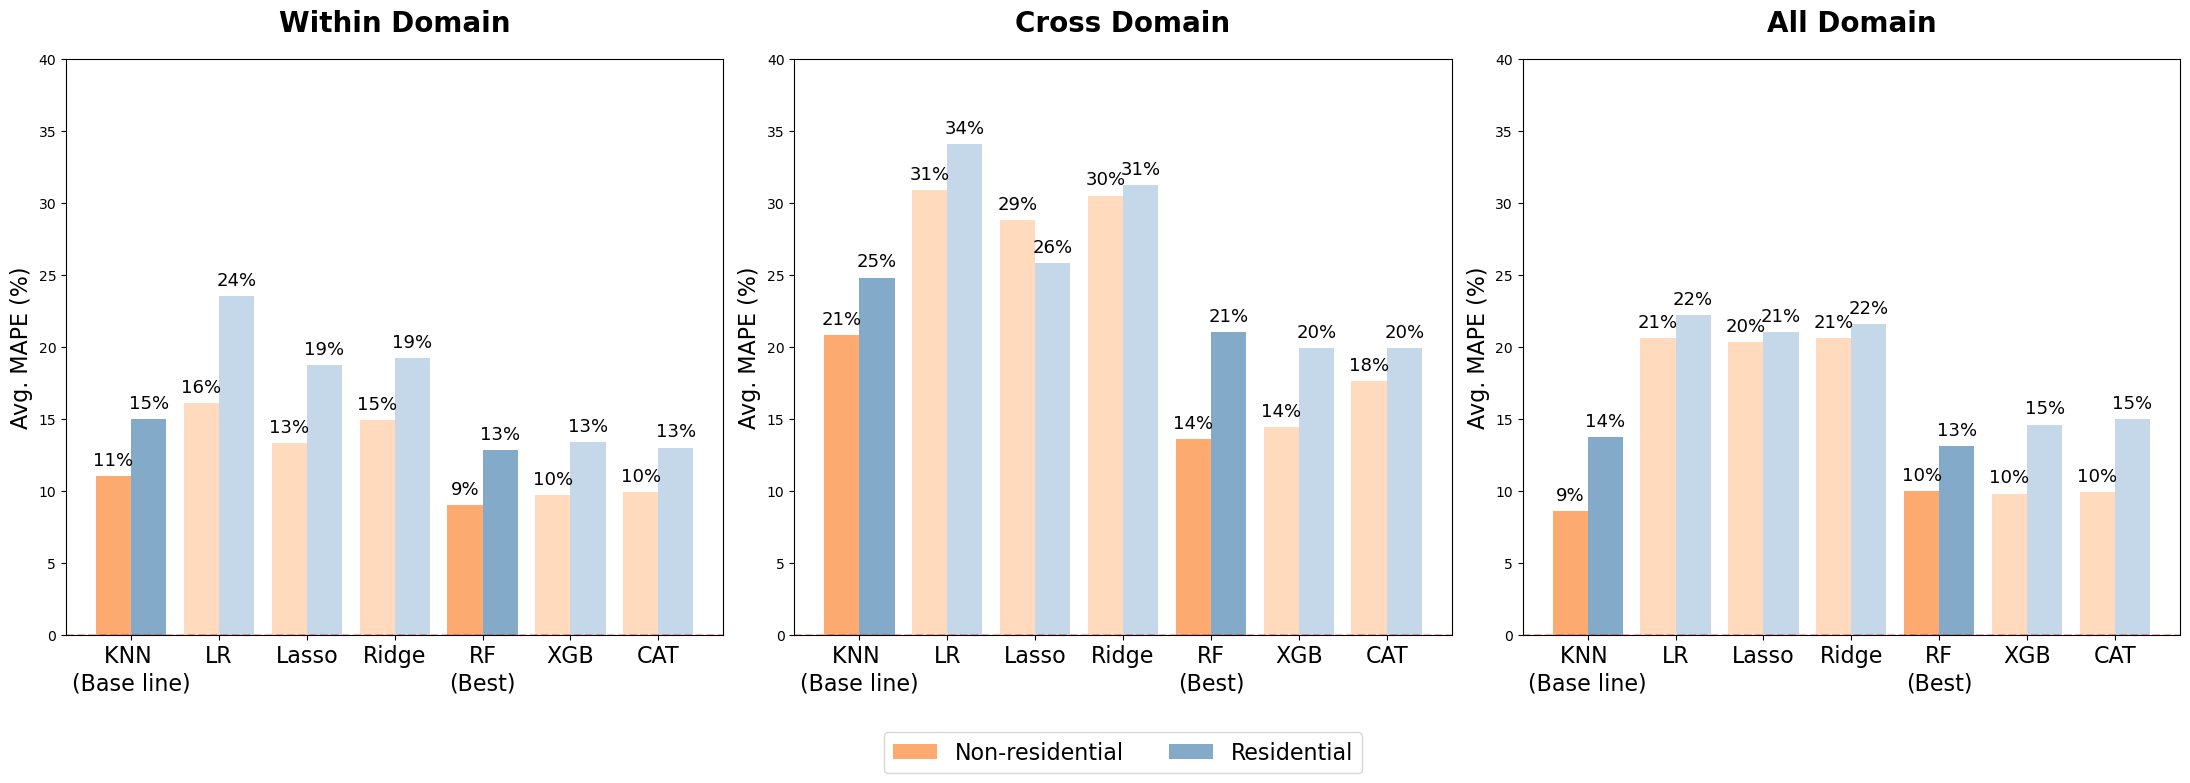

In [54]:
fig = create_model_comparison(comparison_table, metric='MAPE', save_path='../figures/model_plots/00_model_comparison_mape.png', y_limits=(0, 40))

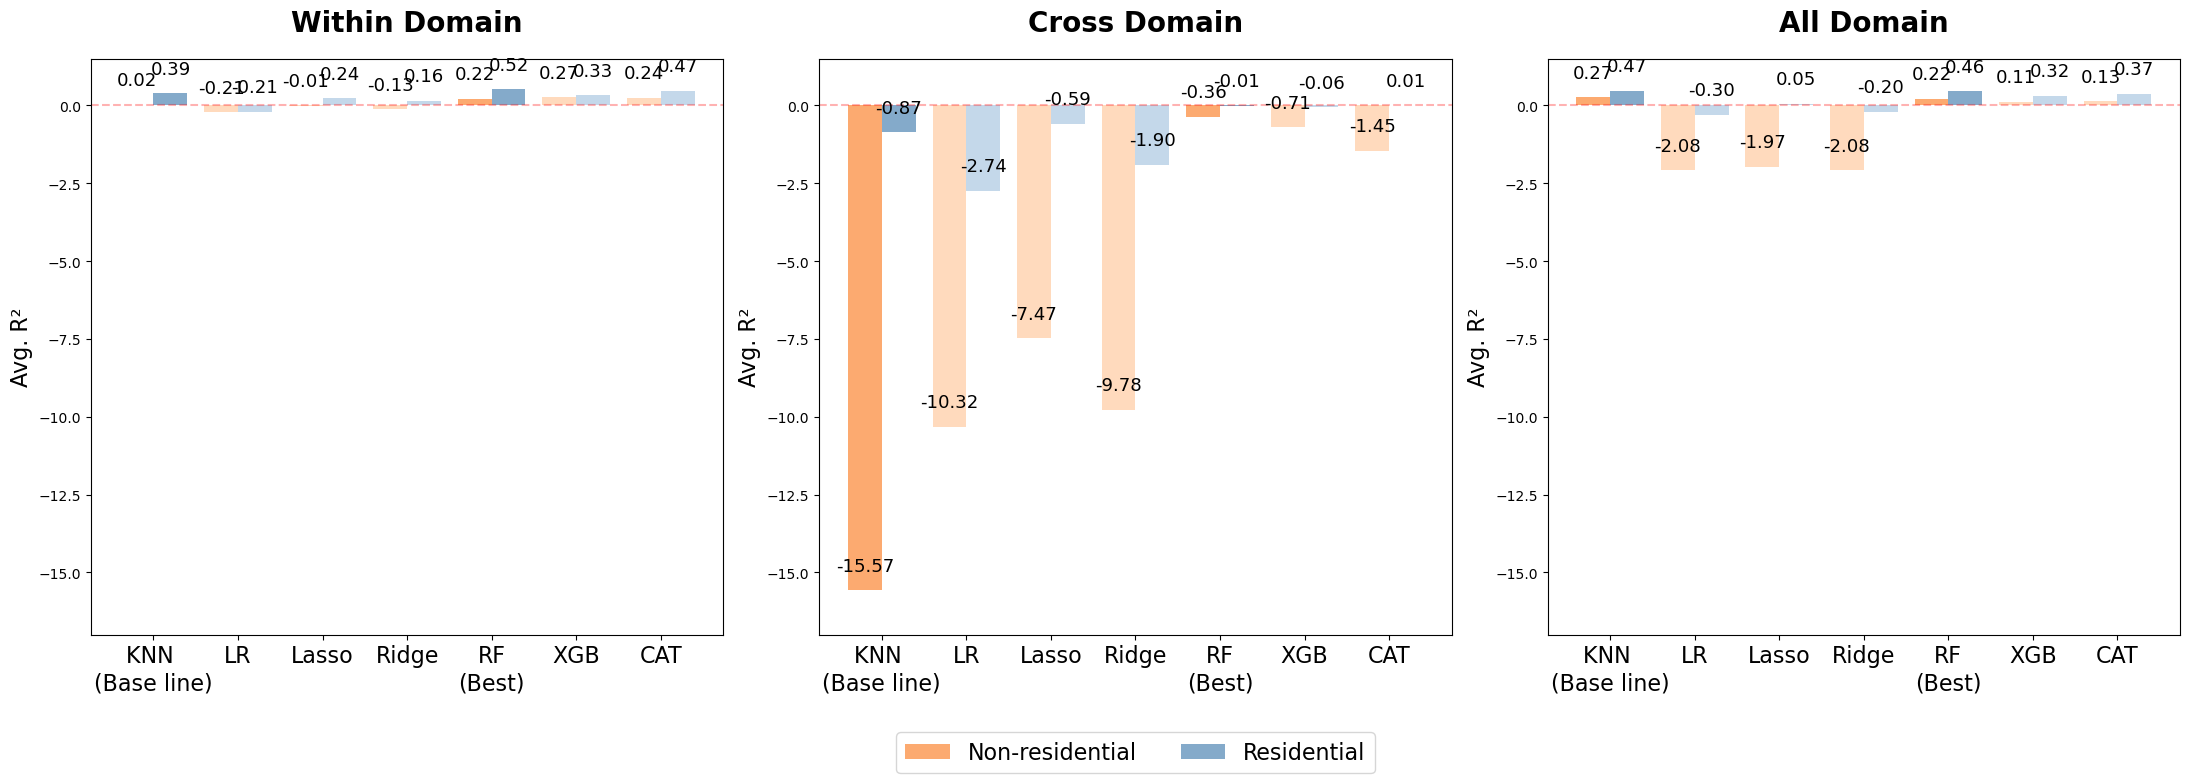

In [55]:
fig = create_model_comparison(comparison_table, metric='R²',save_path='../figures/model_plots/00_model_comparison_r2.png',  y_limits=(-17, 1.5))

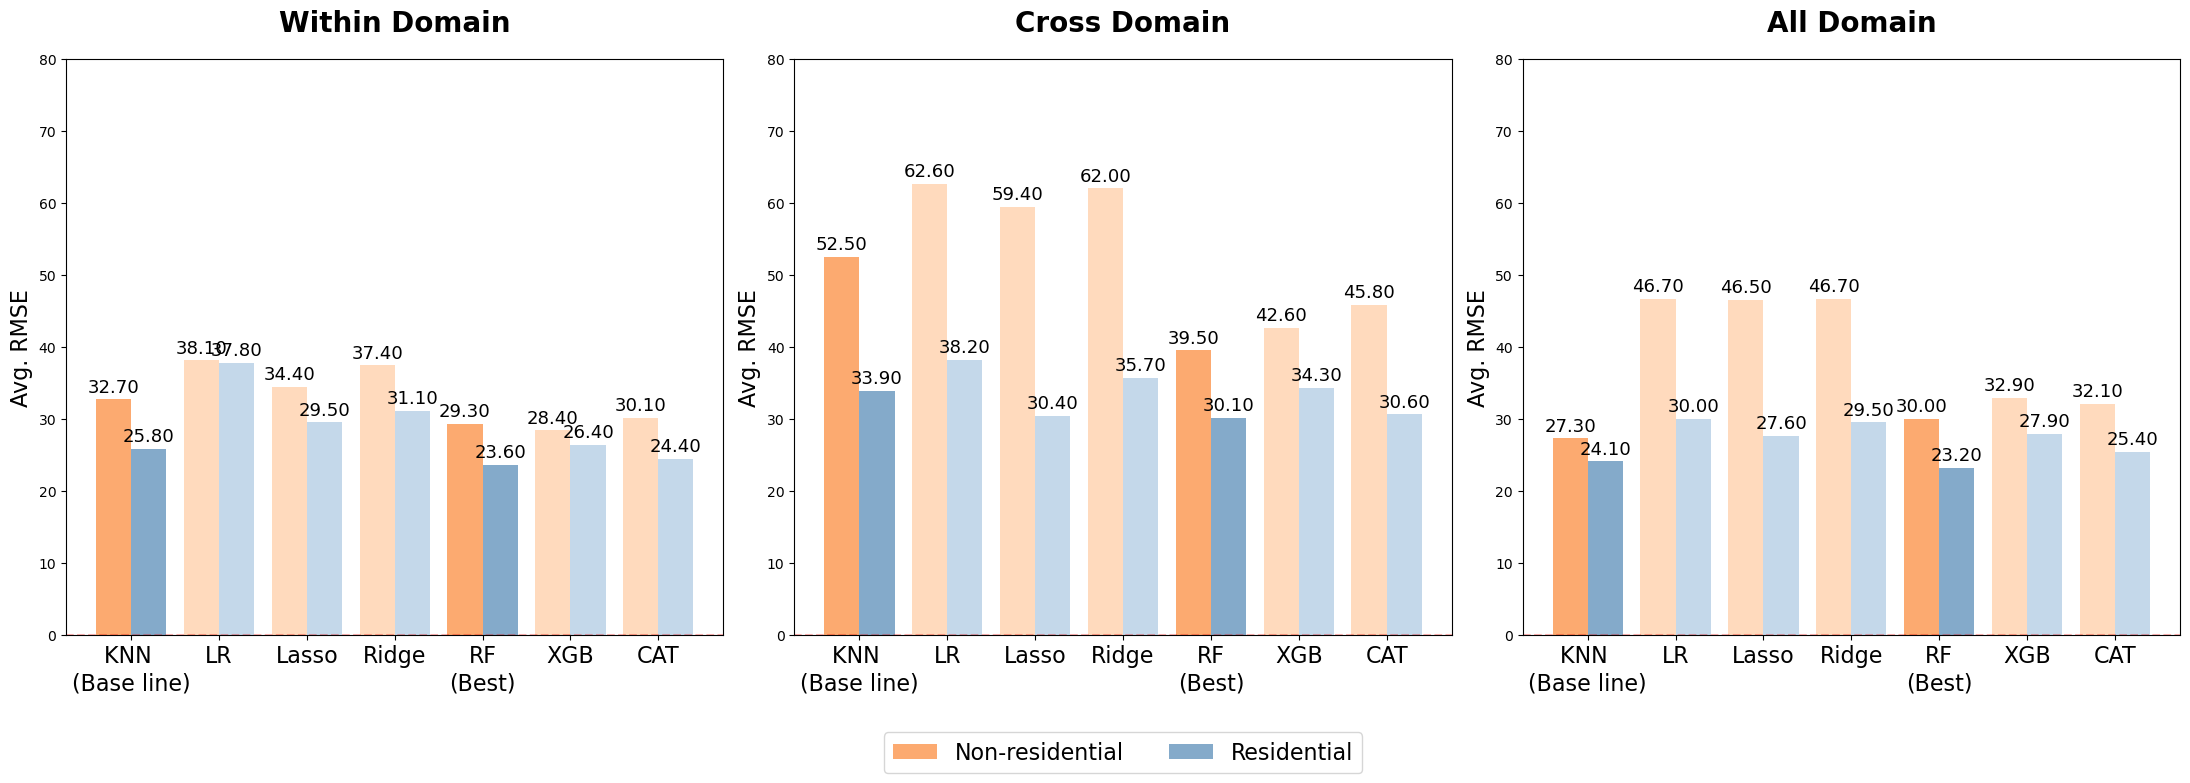

In [56]:
fig = create_model_comparison(comparison_table, metric='RMSE',save_path='../figures/model_plots/00_model_comparison_rmse.png',  y_limits=(0, 80))